# CMA/ES - Hierarchical - Gorgo11 - 5 try: EM fits MSE scaled, p/theta

Redoing MSE EM Scaled with additional connectivity parameters

In [43]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [90]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


## Reload data

In [91]:
# both output layers
%cd /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/
results_optim_tracking = np.load('outputs/cmaes_alliter_tracking-92b3f3b3-9c2f-447f-a0de-16795d92e96e.npy').item()


/nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018


In [92]:
candidates_parameters = np.array(results_optim_tracking['candidates'])
fitness = np.array(results_optim_tracking['fitness'])
parameter_names_sorted = results_optim_tracking['parameter_names_sorted']

In [93]:
parameter_names_sorted

['M',
 'lapse_rate',
 'ratio_hierarchical',
 'sigma_baseline',
 'sigmax',
 'sparsity',
 'threshold']

In [94]:
metric = 'dist_emfit_scaled'

df_all_fits = pd.DataFrame.from_items([('step', np.arange(fitness.size)), 
                                       (metric, np.ma.masked_greater(fitness.flatten(), 1e8))] + 
                                      [(param, candidates_parameters[:, param_i]) 
                                           for param_i, param in enumerate(parameter_names_sorted)])
df_all_fits.loc[:, 'M'] = df_all_fits['M'].astype(int)

In [95]:
ratio_hierarchical, M_lower, M_higher = utils.fix_ratiohierarchical(
    df_all_fits['M'], df_all_fits['ratio_hierarchical'])
df_all_fits.loc[:, 'ratio_hierarchical'] = ratio_hierarchical
df_all_fits.loc[:, 'M_lower'] = M_lower
df_all_fits.loc[:, 'M_higher'] = M_higher

In [96]:
df_all_fits.loc[:, metric + "_log"] = np.log(df_all_fits[metric])
df_all_fits.loc[:, metric + "_log10"] = np.log10(df_all_fits[metric])

In [97]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 100

df_best_fits = df_all_fits[df_all_fits[metric] < LL_max_cutoff]

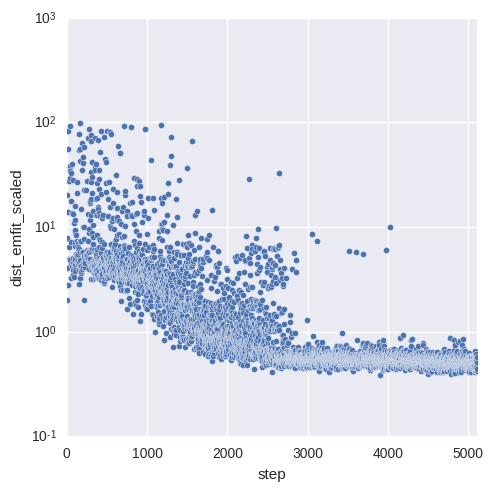

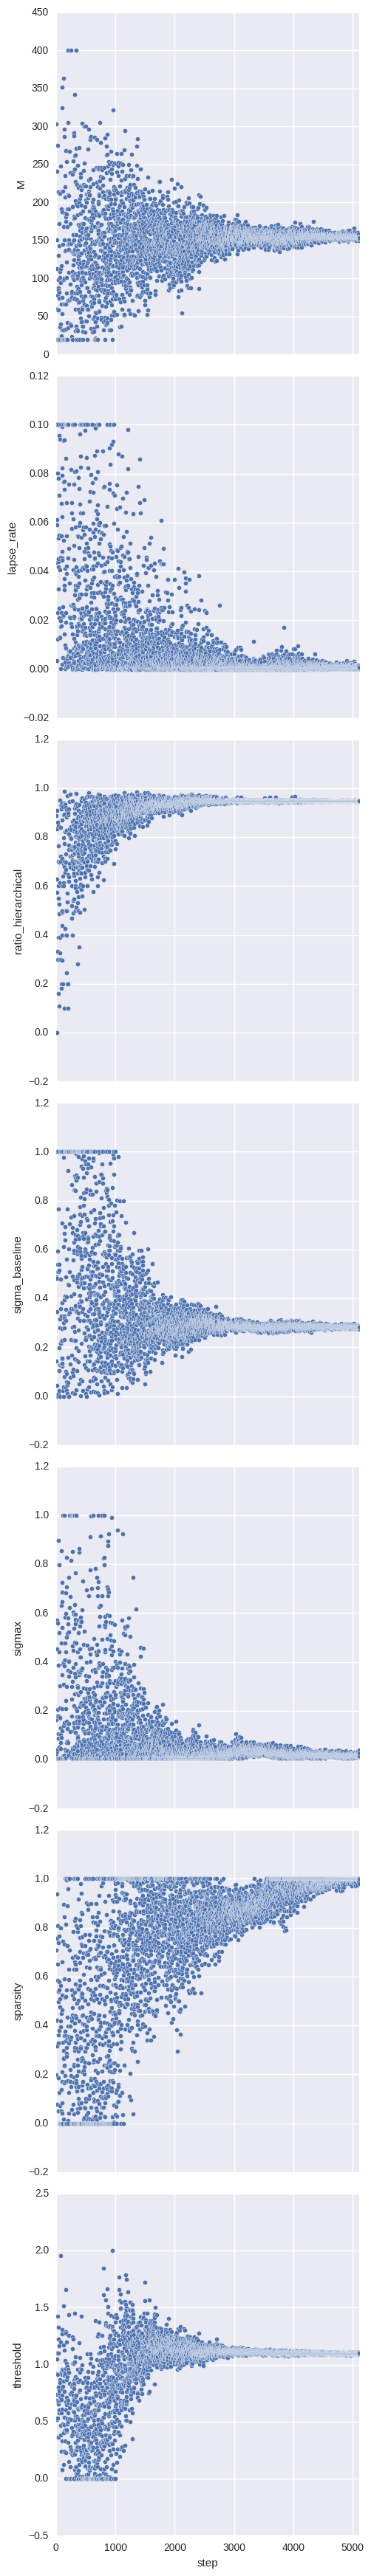

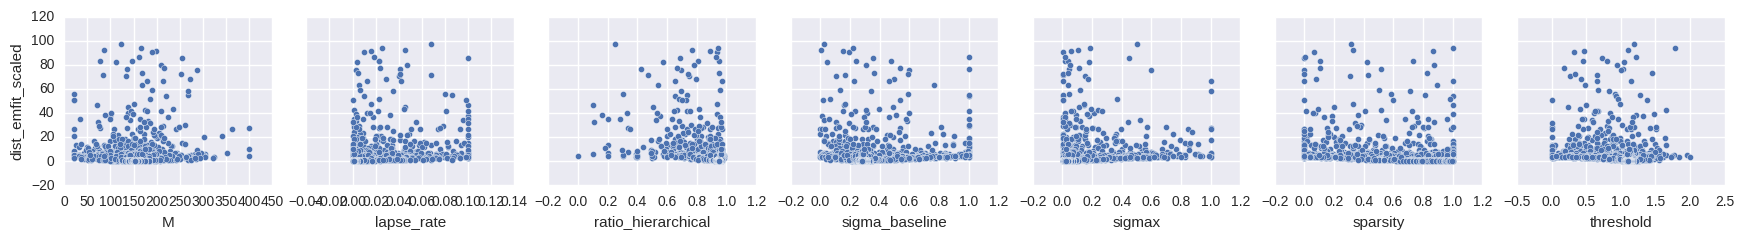

In [98]:
# Learning curve
g = sns.pairplot(df_best_fits,
             y_vars=[metric],
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max())
     )
g.set(yscale = 'log')


# Check training of parameters
g = sns.pairplot(df_best_fits,
             y_vars=parameter_names_sorted,
             x_vars=['step'],
             size=5
            )
g.set(xlim=(-1, df_best_fits['step'].max()))


# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=parameter_names_sorted,
             y_vars=[metric],
            )



In [99]:
# Filter the start of steps only
df_cmaes_traj = df_best_fits[df_best_fits['step'] < 2000]
# result_to_color = np.array(df_cmaes_traj['step'])
result_to_color = np.array(df_cmaes_traj[metric + "_log10"])
# result_to_color = np.log(result_to_color)

# parameters = ['M', 'ratio_hierarchical', 'sigma_baseline']
parameters = ['lapse_rate', 'sigmax', 'sigma_baseline']

text = ['> %s' % (x) for x in result_to_color]

trace1 = go.Scatter3d(
        x = df_cmaes_traj[parameters[0]],
        y = df_cmaes_traj[parameters[1]],
        z = df_cmaes_traj[parameters[2]],
        text = text,
        mode = 'markers',
        marker = go.Marker(
            color = result_to_color,
            size = 8,
            colorscale='Viridis',
            opacity=0.7
        )
    )
data = [trace1]
layout = go.Layout(
    title='Landscape for NLL92',
    autosize=False,
    width=700,
    height=700,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0),
    scene=go.Scene(
        xaxis=go.XAxis(
            title=parameters[0],
        ),
        yaxis=go.YAxis(
            title=parameters[1],
        ),
        zaxis=go.ZAxis(
            title=parameters[2],
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Check parameters values obtained

In [158]:
df_topparams = df_best_fits.sort_values(by='step', ascending=False).head(50)
df_topparams = df_best_fits.sort_values(by=metric, ascending=True).head(100)
params_mean = df_topparams.median()
params_std = df_topparams.std()
for param in parameter_names_sorted + ['M_lower', 'M_higher', metric]:
    print("%s   %.3f +- %.3f" % (param, params_mean[param], params_std[param]))

df_bestparams = df_best_fits.sort_values(by=metric).iloc[4].to_dict()
df_bestparams

M   154.000 +- 4.658
lapse_rate   0.001 +- 0.001
ratio_hierarchical   0.948 +- 0.001
sigma_baseline   0.284 +- 0.006
sigmax   0.020 +- 0.010
sparsity   1.000 +- 0.038
threshold   1.098 +- 0.008
M_lower   8.000 +- 0.000
M_higher   146.000 +- 4.658
dist_emfit_scaled   0.439 +- 0.016


{'M': 154.0,
 'M_higher': 146.0,
 'M_lower': 8.0,
 'dist_emfit_scaled': 0.40627589971488776,
 'dist_emfit_scaled_log': -0.9007227942259961,
 'dist_emfit_scaled_log10': -0.39117893925682823,
 'lapse_rate': 0.0009723711924687246,
 'ratio_hierarchical': 0.948051948051948,
 'sigma_baseline': 0.2812036747773091,
 'sigmax': 0.014628035667161204,
 'sparsity': 1.0,
 'step': 4834.0,
 'threshold': 1.0933712876775858}

In [ ]:
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='sample',
                             experiment_id='gorgo11',
                             type_layer_one='feature',
                             output_both_layers=None,
                             normalise_weights=1,
                             normalise_gain=None,
                             ratio_hierarchical=0.5,
                             threshold=1.0,                  
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=10,
                             num_repetitions=5,
                             code_type='hierarchical',
                             slice_width=0.07,
                             burn_samples=10,
                             ratio_conj=0.7,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=1500, 
                             filter_datapoints_selection='random'
                             )

df_bestparams

experiment_parameters.update(df_bestparams)
for key in ['M', 'M_higher', 'M_lower']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=False) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

Arguments: ['-f', '/run/user/5201/jupyter/kernel-58b31e0c-d863-41b3-a022-aaf898fff03f.json']

        Given a single experiment_id, will run the model on all T in the experimental data.
        Computes several metrics (LL, BIC) and can additionally sample from the model and check the Mixture model
        summary statistics fits.

        If inference_method is not none, also fits a EM mixture model, get the precision and the fisher information
    
Doing a piece of work for launcher_do_fitexperimentsinglet
{'M_layer_one': 400, 'code_type': 'hierarchical', 'verbose': False, 'selection_num_samples': 1, 'subaction': '', 'load_all_from_parameters_file': False, 'pylab': True, 'specific_stimuli_random_centers': False, 'enforce_min_distance': 0.17, 'result_computation': '', 'threshold': 1.0933712876775858, 'slice_width': 0.07, 'rc_scale': 0.5, 'autoset_parameters': True, 'M_lower': 8, 'normalise_gain': True, 'job_name': '', 'experiment_data_dir': '../../experimental_data/', 'normalise_weigh

initial loglikelihood: -1065.21
Loglikelihood: 279.63
top 90% loglike: 385.05
 get precision...
 fit mixture model...

>>> Setting up 2 nitems, 810 datapoints
-> Building HierarchicalRandomNetwork
create feature network, R=2, M=8, autoset: 1
done, output_both_layers:1, M_higher 146, M_lower 8
== DataGeneratorRfn ==
Size: 810, 2 items/times.
sigma_x 0.0149, sigma_y 1.02e-05 sigma_baseline 0.286 renormalized: 1
-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
>> Computing LL all N...
>> Computing LL sum...
-993.8115294174271
>> Computing LL median...
-0.7090716950320726
>> Computing BIC...
Bic: K  3.0
>> Computing LL90/92/95/97...
>> Sampling and fitting mixt model / precision / FI ...
 sampling...
Running inference...
-> Sampling theta, 1 passes
initial loglikelihood: -993.81
Loglikelihood: -351.63
top 90% loglike: -123.01
 get precision...
 fit mixture model...

>>> Setting up 3 nitems, 810 datapoints
-> Building HierarchicalRandomNetwork
create feature netwo

In [151]:
results.keys()

['result_emfit_mixt_kl',
 'result_emfit_mse',
 'result_ll90_sum',
 'result_ll95_sum',
 'result_ll_median',
 'result_ll_sum',
 'result_bic',
 'result_ll92_sum',
 'result_em_fits',
 'result_ll_n',
 'result_emfit_memfid_mse',
 'result_ll97_sum',
 'result_precision',
 'result_emfit_mse_scaled']

In [152]:
print "MSE Mem fid", np.mean(np.sum(results['result_emfit_memfid_mse'], axis=0)), np.std(np.sum(results['result_emfit_memfid_mse'], axis=0))
print "KL loss:", np.mean(np.sum(results['result_emfit_mixt_kl'], axis=0)), np.std(np.sum(results['result_emfit_mixt_kl'], axis=0))
print "EM scaled:", np.mean(np.sum(np.sum(results['result_emfit_mse_scaled'], axis=0), axis=0)), np.std(np.sum(np.sum(results['result_emfit_mse_scaled'], axis=0), axis=0))


MSE Mem fid 23.406810821094986 8.184696053159612
KL loss: 0.7059526224935364 0.07600464967044182
EM scaled: 0.5904881685087016 0.07570315256972658


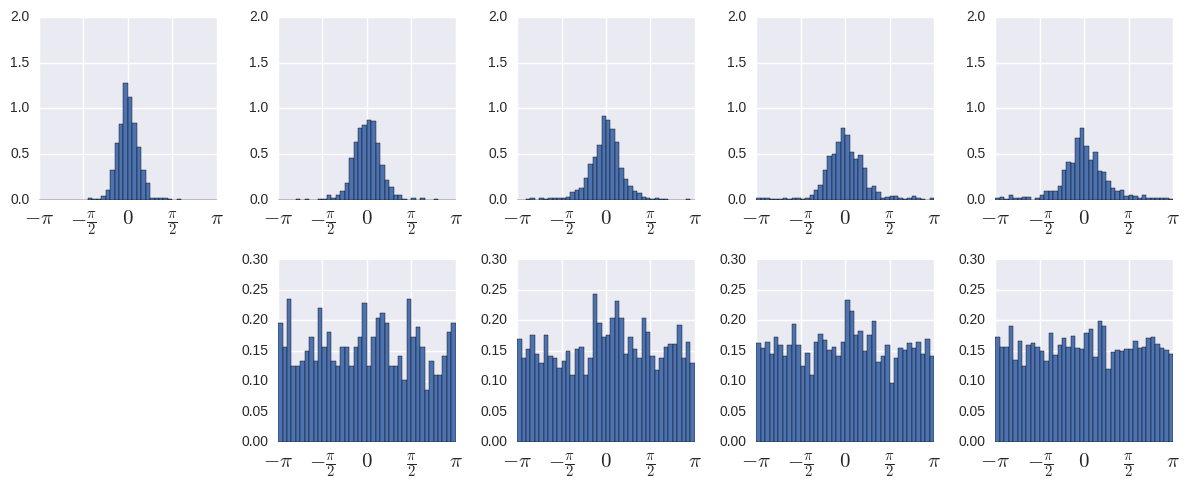

In [153]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig2 = plots_fit_exp.plots_distrib_errors_data_fig2()
    axesFig2[0, 0].figure.set_size_inches((12, 5))
    axesFig2[0, 0].figure.suptitle("")
    axesFig2[0, 0].figure.set_tight_layout(True)

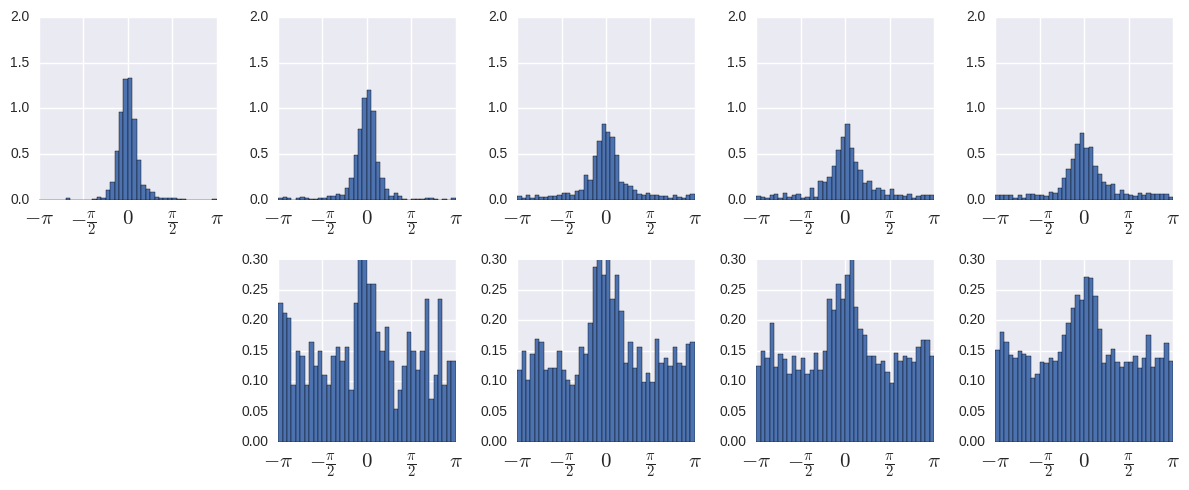

In [154]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig5 = plots_fit_exp.plots_distrib_errors_fig5()
    axesFig5[0, 0].figure.set_size_inches((12, 5))
    axesFig5[0, 0].figure.suptitle("")
    axesFig5[0, 0].figure.set_tight_layout(True)

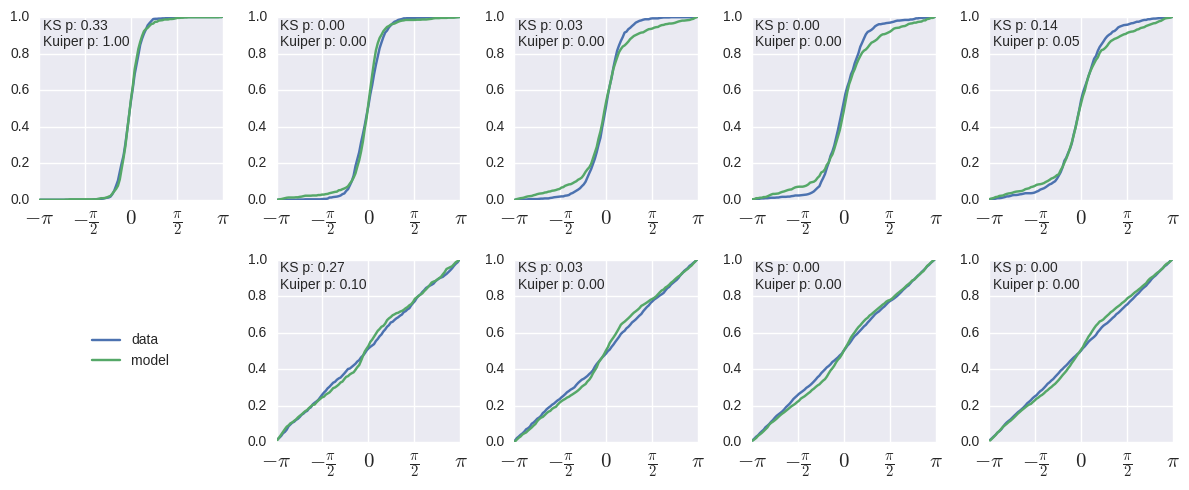

In [155]:
with io.capture_output(display=False, stdout=True) as captured:
    axes, _ = plots_fit_exp.plots_KS_comparison_fig2fig5(bins=100)
    axes[0, 0].figure.set_size_inches((12, 5))
    axes[0, 0].figure.suptitle("")
    axes[0, 0].figure.set_tight_layout(True)

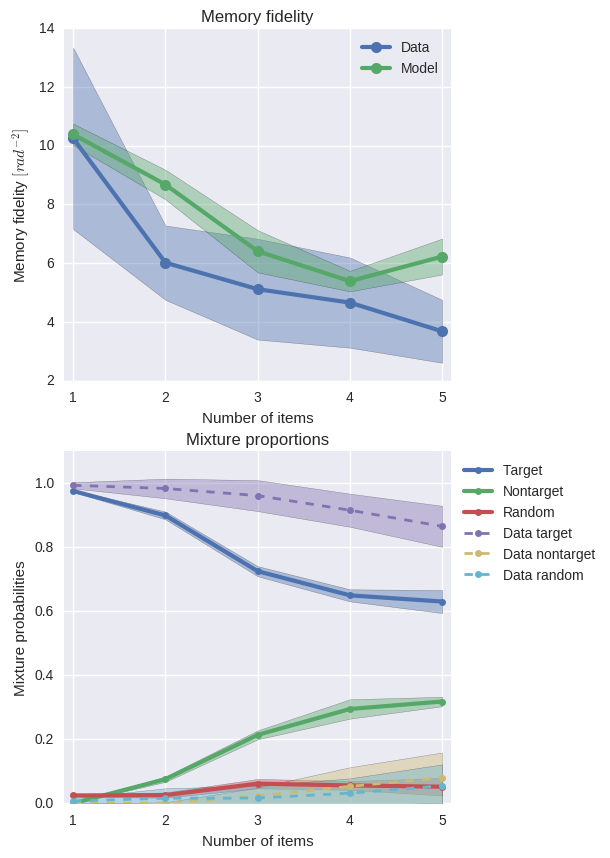

In [157]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=5, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

# Discussion: WRITE ME

In [87]:
# Store figures
dataio = DataIO(output_folder=os.path.join(os.path.abspath("."), "outputs"), 
                label='thesis_hier_gorgo11_emfitscaled_ptheta', calling_function='')
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_sigmabaseline_cmaes_08_2016')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs/thesis_hier_gorgo11_emfitscaled_ptheta-4904f98c-b376-47f2-a031-e6f09fdda27c ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_sigmabaseline_cmaes_08_2016/fitexperiment_sigmabaseline_cmaes_08_2016_cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_sigmabaseline_cmaes_08_2016/cmaes_hier_gorgo11_5try_emfitscaled_Mratiosigmaxsigmabaselinelapserateptheta_repetitions3_181018/outputs 

In [88]:
axesFig2[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_human_{label}_{unique_id}.pdf"))
axesFig5[0, 0].figure.savefig(dataio.create_formatted_filename("histograms_model_{label}_{unique_id}.pdf"))
axes[0, 0].figure.savefig(dataio.create_formatted_filename("ecdf_model_{label}_{unique_id}.pdf"))
axesFig6Fig13[0].figure.savefig(dataio.create_formatted_filename("emfits_model_{label}_{unique_id}.pdf"))